In [1]:
!pip install llama-index-experimental

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install -r azure-search-vector-python-llamaindex-sample-requirements.txt --quiet


[notice] A new release of pip is available: 23.0.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [3]:
# !pip install html5lib lxml

In [4]:
import logging
import sys
# from IPython.display import Markdown, display

import pandas as pd
from llama_index.experimental.query_engine import PandasQueryEngine


logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

In [5]:
from dotenv import load_dotenv
from azure.identity import DefaultAzureCredential
from azure.core.credentials import AzureKeyCredential
import os

In [6]:
load_dotenv(override=True) # take environment variables from .env.

# Make sure your .env file has values for the following environment variables
endpoint = os.environ["AZURE_SEARCH_SERVICE_ENDPOINT"]
credential = AzureKeyCredential(os.environ["AZURE_SEARCH_ADMIN_KEY"]) if len(os.environ["AZURE_SEARCH_ADMIN_KEY"]) > 0 else DefaultAzureCredential()
# index_name = os.environ["AZURE_SEARCH_INDEX"]
azure_openai_endpoint = os.environ["AZURE_OPENAI_ENDPOINT"]
# Llama Index does not support RBAC authentication, an API key is required
azure_openai_key = os.environ["AZURE_OPENAI_KEY"]
if len(azure_openai_key) == 0:
    raise Exception("API key required")
azure_openai_embedding_model = os.environ["AZURE_OPENAI_EMBEDDING_MODEL"]
azure_openai_embedding_deployment = os.environ["AZURE_OPENAI_EMBEDDING_DEPLOYMENT"]
azure_openai_chatgpt_deployment = os.environ["AZURE_OPENAI_CHATGPT_DEPLOYMENT"]
azure_openai_api_version = os.environ["AZURE_OPENAI_API_VERSION"]
# embedding_dimensions = int(os.getenv("AZURE_OPENAI_EMBEDDING_DIMENSIONS", 1536))

In [7]:
from llama_index.llms.azure_openai import AzureOpenAI
llm = AzureOpenAI(
    deployment_name=azure_openai_chatgpt_deployment,
    api_version=azure_openai_api_version,
    azure_endpoint=azure_openai_endpoint,
    api_key=azure_openai_key
)

In [8]:
from llama_index.core import (
    SimpleDirectoryReader,
    StorageContext,
    VectorStoreIndex,
)
from llama_index.core.settings import Settings

Settings.llm = llm

In [9]:
import pandas as pd
from bs4 import BeautifulSoup
import requests

# url = 'https://www.espn.com/nhl/player/_/id/2563060'
url = 'https://www.espncricinfo.com/records/most-runs-in-career-223646'
tables = pd.read_html(url)
df = tables[0]
df

,Player,Span,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0,4s,6s
0,SR Tendulkar (IND),1989-2013,200,329,33,15921,248*,53.78,29437+,54.04,51,68,14,2058+,69
1,RT Ponting (AUS),1995-2012,168,287,29,13378,257,51.85,22782,58.72,41,62,17,1509,73
2,JH Kallis (ICC/SA),1995-2013,166,280,40,13289,224,55.37,28903,45.97,45,58,16,1488,97
3,R Dravid (ICC/IND),1996-2012,164,286,32,13288,270,52.31,31258,42.51,36,63,8,1654,21
4,AN Cook (ENG),2006-2018,161,291,16,12472,294,45.35,26562,46.95,33,57,9,1442,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,JH Edrich (ENG),1963-1976,77,127,9,5138,310*,43.54,12102+,37.23,12,24,6,548+,11
103,Tamim Iqbal (BAN),2008-2023,70,134,2,5134,206,38.89,8852,57.99,10,31,11,655,41
104,A Ranatunga (SL),1982-2000,93,155,12,5105,135*,35.69,8672+,49.96,4,38,12,534+,40
105,AM Rahane (IND),2013-2023,85,144,12,5077,188,38.46,10256,49.50,12,26,10,578,35


In [10]:
query_engine = PandasQueryEngine(df=df, verbose=True)

In [12]:
response = query_engine.query(
    "Which player has scored highest runs?",
)

INFO:httpx:HTTP Request: POST https://genai-azure-openai-eq-swe.openai.azure.com//openai/deployments/gpt-4-turbo/chat/completions?api-version=2024-02-01 "HTTP/1.1 200 OK"
HTTP Request: POST https://genai-azure-openai-eq-swe.openai.azure.com//openai/deployments/gpt-4-turbo/chat/completions?api-version=2024-02-01 "HTTP/1.1 200 OK"
> Pandas Instructions:
```
df.loc[df['Runs'].idxmax(), 'Player']
```
> Pandas Output: SR Tendulkar (IND)


In [13]:
response = query_engine.query(
    "Which player has scored highest runs for Australia?",
)

INFO:httpx:HTTP Request: POST https://genai-azure-openai-eq-swe.openai.azure.com//openai/deployments/gpt-4-turbo/chat/completions?api-version=2024-02-01 "HTTP/1.1 200 OK"
HTTP Request: POST https://genai-azure-openai-eq-swe.openai.azure.com//openai/deployments/gpt-4-turbo/chat/completions?api-version=2024-02-01 "HTTP/1.1 200 OK"
> Pandas Instructions:
```
df[df['Player'].str.contains('AUS')].sort_values(by='Runs', ascending=False).iloc[0]['Player']
```
> Pandas Output: RT Ponting (AUS)


In [14]:
response = query_engine.query(
    "What are the average runs of all batsmen?",
)

INFO:httpx:HTTP Request: POST https://genai-azure-openai-eq-swe.openai.azure.com//openai/deployments/gpt-4-turbo/chat/completions?api-version=2024-02-01 "HTTP/1.1 200 OK"
HTTP Request: POST https://genai-azure-openai-eq-swe.openai.azure.com//openai/deployments/gpt-4-turbo/chat/completions?api-version=2024-02-01 "HTTP/1.1 200 OK"
> Pandas Instructions:
```
df['Runs'].mean()
```
> Pandas Output: 7517.672897196262


INFO:httpx:HTTP Request: POST https://genai-azure-openai-eq-swe.openai.azure.com//openai/deployments/gpt-4-turbo/chat/completions?api-version=2024-02-01 "HTTP/1.1 200 OK"
HTTP Request: POST https://genai-azure-openai-eq-swe.openai.azure.com//openai/deployments/gpt-4-turbo/chat/completions?api-version=2024-02-01 "HTTP/1.1 200 OK"
> Pandas Instructions:
```
df.hist()
```
INFO:matplotlib.font_manager:generated new fontManager
generated new fontManager
> Pandas Output: [[<Axes: title={'center': 'Mat'}> <Axes: title={'center': 'Inns'}>
  <Axes: title={'center': 'NO'}>]
 [<Axes: title={'center': 'Runs'}> <Axes: title={'center': 'Ave'}>
  <Axes: title={'center': 'SR'}>]
 [<Axes: title={'center': '100'}> <Axes: title={'center': '50'}>
  <Axes: title={'center': '0'}>]]


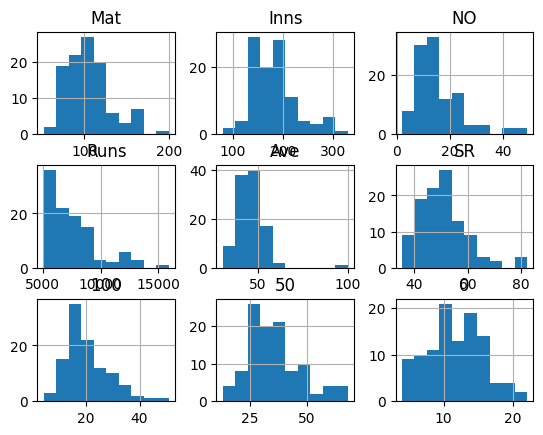

In [15]:
response = query_engine.query(
    "Can you plot histogram?",
)